Explanation of the Feature Selection and Model Improvement Process


1. Dataset Preparation
Loaded the dataset and selected a subset of features based on domain relevance (columns_test_1).
Focused on individualizing data by normalizing patient biomarkers against baseline values.
2. Target Engineering
Created a CRS_in_6_hours target variable to predict if CRS would occur within six hours.
3. Data Splitting
Split data into training and test sets based on patient-specific quantile-based cutoffs to ensure a realistic temporal separation.
4. Oversampling for Imbalanced Classes
Used RandomOverSampler to balance the dataset, addressing the class imbalance problem to improve the model’s ability to detect minority classes.
5. Feature Scaling
Applied standard scaling to normalize features, reducing bias in the model's interpretation of input ranges.
6. Initial Feature Importance Extraction
Trained an initial XGBoost classifier and extracted feature importance values.
Identified the top 100 features based on their importance scores for subsequent refinement.
7. Recursive Feature Elimination (RFE)
Used RFE to iteratively rank and prune features. This step assessed subsets of features to find the combination that maximized model performance.
Performance metrics such as accuracy, AUC-ROC, and F1-score were tracked to identify the optimal number of features.
8. Final Feature Set
Selected the optimal subset of features based on RFE results and retrained the model using these features.
9. Threshold Optimization
Evaluated various thresholds for converting predicted probabilities into binary decisions.
Determined the best threshold that maximized the F1-score, optimizing for a balance between precision and recall.
10. Model Evaluation
Assessed the final model's performance using accuracy, AUC-ROC, F1-score, and a classification report.
Visualized feature importances for the selected features.
Key Insights for the Report:
Feature Importance: Feature selection was guided by domain knowledge and quantitative importance rankings, ensuring relevance and reduced overfitting.
Balanced Training: Oversampling resolved imbalances, improving generalization for underrepresented classes.
Refinement through RFE: Iterative feature elimination systematically determined the most predictive variables.
Threshold Tuning: Customized thresholds optimized the trade-off between false positives and false negatives.

/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_88163/2863376459.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['CRS_in_6_hours'] = 0


Class distribution after oversampling:
CRS_in_6_hours
0    49866
1    49866
Name: count, dtype: int64
Accuracy: 0.8495218922999497
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     99159
           1       0.95      0.18      0.31     22048

    accuracy                           0.85    121207
   macro avg       0.90      0.59      0.61    121207
weighted avg       0.86      0.85      0.80    121207

AUC-ROC Score: 0.7661534473261932
Feature Importances:
                         Feature   Importance
6                           TIE2  8937.902344
7                          CRTAM   767.980713
4                    Highest CRP   235.769440
5                            IL8    72.418442
21                      TNFRSF21     6.100531
19                          MMP7     4.210517
16                          HO-1     3.923524
12                         Gal-9     2.625126
18                     TNFRSF12A     2.213370
11 

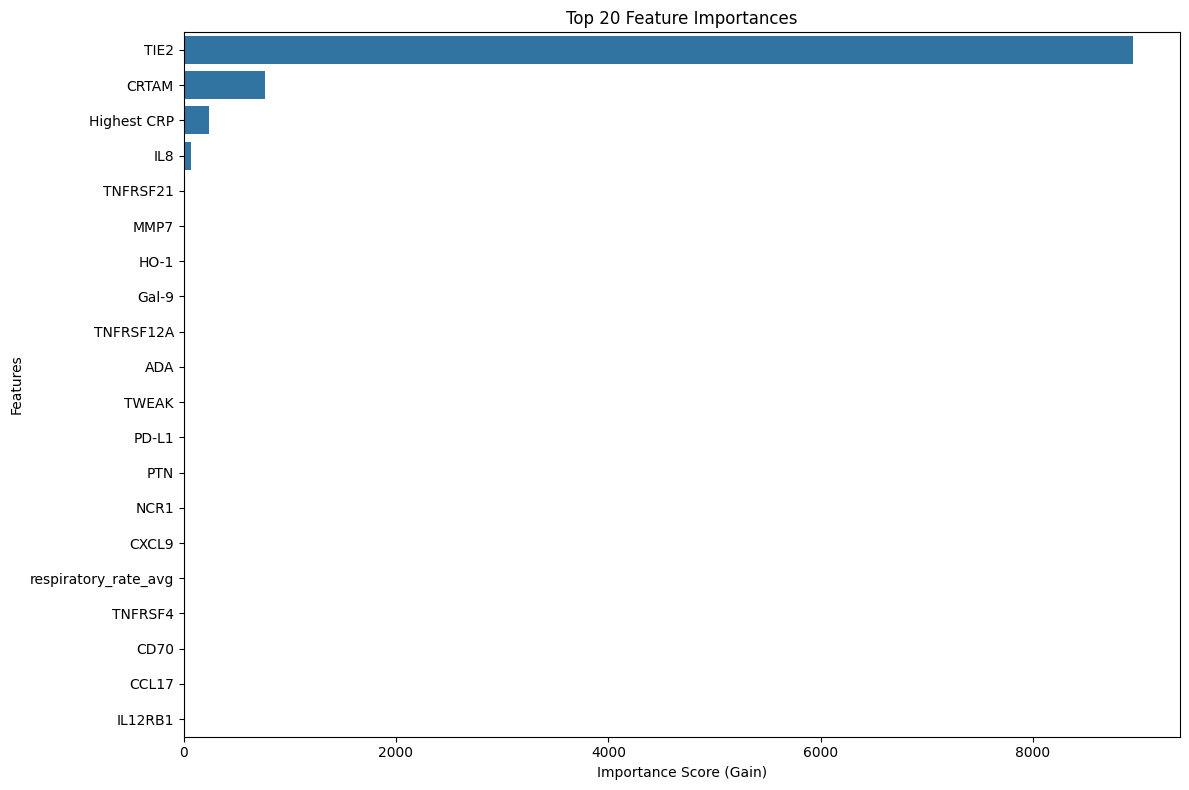

Best Threshold: 0.01
Best F1-Score: 0.3363708811198503
Accuracy with Best Threshold: 0.8419810737003638
AUC-ROC with Best Threshold: 0.7682748436941763
Classification Report with Best Threshold:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91     99159
           1       0.71      0.22      0.34     22048

    accuracy                           0.84    121207
   macro avg       0.78      0.60      0.62    121207
weighted avg       0.82      0.84      0.81    121207



In [3]:
# -*- coding: utf-8 -*-
"""modeling-V2.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1LUhqv2W-tbxWOvHuuKkrRGAPu19n60FN
"""

# !pip install tslearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Load the dataset
df = pd.read_csv("../../Datasets/final_data_clipped.csv",low_memory=False)
df.head(5)

# Define the complete_set as per your existing code
complete_set = ['PT_ID','CRS on date (0 No, 1 Yes)','Agent (JNJ/BMS/Caribou)','datetime', 'spo2_avg', 'pulse_rate_avg','respiratory_rate_avg', 'covered_skin_temperature_avg','covered_axil_temperature_avg','Highest Ferritin',
 'Highest CRP','IL8',
 'TNFRSF9',
 'TIE2',
 'MCP-3',
 'CD40-L',
 'IL-1 alpha',
 'CD244',
 'EGF',
 'ANGPT1',
 'IL7',
 'PGF',
 'IL6',
 'ADGRG1',
 'MCP-1',
 'CRTAM',
 'CXCL11',
 'MCP-4',
 'TRAIL',
 'FGF2',
 'CXCL9',
 'CD8A',
 'CAIX',
 'MUC-16',
 'ADA',
 'CD4',
 'NOS3',
 'IL2',
 'Gal-9',
 'VEGFR-2',
 'CD40',
 'IL18',
 'GZMH',
 'KIR3DL1',
 'LAP TGF-beta-1',
 'CXCL1',
 'TNFSF14',
 'IL33',
 'TWEAK',
 'PDGF subunit B',
 'PDCD1',
 'FASLG',
 'CD28',
 'CCL19',
 'MCP-2',
 'CCL4',
 'IL15',
 'Gal-1',
 'PD-L1',
 'CD27',
 'CXCL5',
 'IL5',
 'HGF',
 'GZMA',
 'HO-1',
 'CX3CL1',
 'CXCL10',
 'CD70',
 'IL10',
 'TNFRSF12A',
 'CCL23',
 'CD5',
 'CCL3',
 'MMP7',
 'ARG1',
 'NCR1',
 'DCN',
 'TNFRSF21',
 'TNFRSF4',
 'MIC-A/B',
 'CCL17',
 'ANGPT2',
 'PTN',
 'CXCL12',
 'IFN-gamma',
 'LAMP3',
 'CASP-8',
 'ICOSLG',
 'MMP12',
 'CXCL13',
 'PD-L2',
 'VEGFA',
 'IL4',
 'LAG3',
 'IL12RB1',
 'IL13',
 'CCL20',
 'TNF',
 'KLRD1',
 'GZMB',
 'CD83',
 'IL12',
 'CSF-1',]

# Select the subset of columns
columns_test_1 = complete_set
df_subset = df[columns_test_1]
df_subset.head(5)



# Filter for JNJ and BMS agents
df_JNJ = df_subset[(df_subset['Agent (JNJ/BMS/Caribou)']=='JNJ') | (df_subset['Agent (JNJ/BMS/Caribou)']=='JNJ OOS')]
df_BMS = df_subset[(df_subset['Agent (JNJ/BMS/Caribou)']=='BMS')]

# Individualize the data by subtracting baseline values

##### Change this to categoty = "BMS" and data = df_BMS.copy() to calculate features for BMS########
##### Change this to categoty = "JNJ" and data = df_JNJ.copy() to calculate features for BMS########

category = "JNJ"
data = df_JNJ.copy()

baseline = data.groupby('PT_ID').first().reset_index()

if category == "BMS":
  missing_cols = set(complete_set) - set(df.columns)
  non_numeric_features = ['PT_ID', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'datetime']
  numeric_features = [col for col in data.columns if col not in non_numeric_features]
  if missing_cols:
    print(f"\nWarning: The following columns are missing from the dataset and will be excluded: {missing_cols}")
    complete_set = [col for col in complete_set if col not in missing_cols]
  for col in numeric_features:
    data[col] = pd.to_numeric(data[col], errors='coerce')

  missing_values = data[numeric_features].isnull().sum()
  print("\nMissing Values in Numeric Features:")
  print(missing_values[missing_values > 0])

  # Fill missing values with the median of each column
  data[numeric_features] = data[numeric_features].fillna(data[numeric_features].median())

else:

  # Subtract the baseline values for numeric columns
  columns_to_individualize = [col for col in columns_test_1 if col not in ['PT_ID', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)','datetime']]

  for col in columns_to_individualize:
      data[col] = pd.to_numeric(data[col], errors='coerce')
      data[col] = data[col] - data.groupby('PT_ID')[col].transform('first')

data.head()

# Assign CRS_in_6_hours
from datetime import timedelta

def assign_crs_in_6_hours(data):
    """
    Assign CRS_in_6_hours for each row based on whether `datetime + 6 hours` falls within a CRS occurrence time frame.
    """
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.sort_values(by=['PT_ID', 'datetime'])

    # Initialize a new column
    data['CRS_in_6_hours'] = 0

    # Process each patient group separately
    for pt_id, group in data.groupby('PT_ID'):
        group = group.sort_values('datetime')

        # Identify CRS occurrence start and end timeframes
        crs_start = group.index[(group['CRS on date (0 No, 1 Yes)'].shift(1) == 0) &
                                (group['CRS on date (0 No, 1 Yes)'] == 1)].tolist()
        crs_end = group.index[(group['CRS on date (0 No, 1 Yes)'].shift(1) == 1) &
                              (group['CRS on date (0 No, 1 Yes)'] == 0)].tolist()

        # If a CRS event starts but does not end, assume it continues until the last datetime
        if len(crs_start) > len(crs_end):
            crs_end.append(group.index[-1])

        # Assign CRS_in_6_hours for each row
        for start_idx, end_idx in zip(crs_start, crs_end):
            crs_start_time = group.loc[start_idx, 'datetime']
            crs_end_time = group.loc[end_idx, 'datetime']

            # Any datetime + 6 hours within the CRS occurrence timeframe is set to 1
            within_crs_timeframe = (group['datetime'] + timedelta(hours=6) >= crs_start_time) & \
                                   (group['datetime'] + timedelta(hours=6) <= crs_end_time)
            data.loc[group[within_crs_timeframe].index, 'CRS_in_6_hours'] = 1

    return data

# Apply the function to your dataset
data = assign_crs_in_6_hours(data)

data.shape

# Additional data exploration
data[data['CRS_in_6_hours']==1]
data[data['CRS_in_6_hours']==1].head(10)

# Define features and target
import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure datetime is in datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Calculate 0.8 quantile cutoff for each patient
quantile_cutoffs = data.groupby('PT_ID')['datetime'].quantile(0.3).reset_index()
quantile_cutoffs.columns = ['PT_ID', 'cutoff_date']

# Merge the cutoff dates back into the original dataframe
data = data.merge(quantile_cutoffs, on='PT_ID')

# Create train and test datasets based on the cutoff date
train_data = data[data['datetime'] < data['cutoff_date']]
test_data = data[data['datetime'] >= data['cutoff_date']]

# Separate features and target
X_train = train_data.drop(columns=['PT_ID', 'datetime', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'CRS_in_6_hours', 'cutoff_date'])
y_train = train_data['CRS_in_6_hours']

X_test = test_data.drop(columns=['PT_ID', 'datetime', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'CRS_in_6_hours', 'cutoff_date'])
y_test = test_data['CRS_in_6_hours']

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, classification_report

# Step 2: Apply Random Oversampling
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_resampled).value_counts())

# Step 3: Convert to XGBoost DMatrix
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 4: Define XGBoost Parameters
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_resampled  # Target variable in the training set
)

scale_pos_weight = class_weights[1] / class_weights[0]

# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'scale_pos_weight': scale_pos_weight
}

# Step 5: Train the XGBoost Model
model = xgb.train(params, dtrain, num_boost_round=100)

# Step 6: Make predictions
y_pred = (model.predict(dtest) > 0.49).astype(int)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Predict probabilities for AUC-ROC
y_prob = model.predict(dtest)
auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc)

# Step 7: Feature Selection using Feature Importances
import pandas as pd

importances = model.get_score(importance_type='gain')  # 'gain' is more informative
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances:")
print(importance_df)

# Select top N features
TOP_N = 20  # Adjust based on your preference
top_features = importance_df['Feature'].head(TOP_N).tolist()
print(f"Top {TOP_N} Features: {top_features}")

# Step 8: Retrain the model with selected features
# Reduce the training and testing data to only include top features
X_train_top = X_train_resampled[top_features]
X_test_top = X_test[top_features]

# Convert to DMatrix again
dtrain_top = xgb.DMatrix(X_train_top, label=y_train_resampled)
dtest_top = xgb.DMatrix(X_test_top, label=y_test)

# Retrain the model with top features
model_top = xgb.train(params, dtrain_top, num_boost_round=100)

# Make predictions with the new model
y_prob_top = model_top.predict(dtest_top)
y_pred_top = (y_prob_top > 0.49).astype(int)  # You can adjust the threshold as needed

# Evaluate the model
print("Accuracy with Top Features:", accuracy_score(y_test, y_pred_top))
print("AUC-ROC with Top Features:", roc_auc_score(y_test, y_prob_top))
print("Classification Report with Top Features:\n", classification_report(y_test, y_pred_top))

# Plot feature importances for top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(TOP_N))
plt.title(f'Top {TOP_N} Feature Importances')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Step 9: Threshold Optimization
from sklearn.metrics import precision_recall_curve, f1_score

def find_best_threshold(y_true, y_prob, step=0.01):
    """
    Find the best threshold to maximize the F1-Score.

    Parameters:
        y_true (array-like): True binary labels.
        y_prob (array-like): Predicted probabilities for the positive class.
        step (float): Step size for threshold search.

    Returns:
        best_threshold (float): Threshold that gives the highest F1-Score.
        best_f1 (float): The highest F1-Score achieved.
    """
    best_threshold = 0.0
    best_f1 = 0.0
    for threshold in np.arange(0, 1 + step, step):
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

# Find the best threshold on the test set
best_threshold_final, best_f1_final = find_best_threshold(y_test, y_prob_top, step=0.01)
print(f"Best Threshold: {best_threshold_final}")
print(f"Best F1-Score: {best_f1_final}")

# Apply the best threshold
y_pred_best = (y_prob_top >= best_threshold_final).astype(int)

# Re-evaluate the model with the best threshold
print("Accuracy with Best Threshold:", accuracy_score(y_test, y_pred_best))
print("AUC-ROC with Best Threshold:", roc_auc_score(y_test, y_prob_top))
print("Classification Report with Best Threshold:\n", classification_report(y_test, y_pred_best))


Feature Selection
Initial Feature Ranking:

The importance of each feature was calculated using the gain metric from the XGBoost classifier after the initial training.
The top 100 features were selected based on their importance scores, allowing the model to focus on the most impactful predictors.
Recursive Feature Elimination (RFE):

RFE was applied to iteratively refine the feature set by selecting subsets of features in steps of 10, starting from 10 and going up to 100.
For each subset, a new model was trained and evaluated to determine its performance using metrics like accuracy, AUC-ROC, and F1-Score.
This process ensured that the model retained only the most relevant features, improving efficiency and reducing noise.
Optimal Feature Set:

The feature subset that achieved the highest accuracy during the RFE process was identified as the optimal set for CRS prediction.
This final set was used for retraining the model to maximize its predictive performance.


# REFECV

In [ ]:
# -*- coding: utf-8 -*-
"""modeling-V2.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1LUhqv2W-tbxWOvHuuKkrRGAPu19n60FN
"""

# Uncomment and run the following lines if the packages are not already installed
# !pip install tslearn
# !pip install xgboost
# !pip install imblearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final_data_clipped.csv")
df.head(5)

# Define the complete_set as per your existing code
complete_set = ['PT_ID','CRS on date (0 No, 1 Yes)','Agent (JNJ/BMS/Caribou)','datetime', 'spo2_avg', 'pulse_rate_avg','respiratory_rate_avg', 'covered_skin_temperature_avg','covered_axil_temperature_avg','Highest Ferritin',
 'Highest CRP','IL8',
 'TNFRSF9',
 'TIE2',
 'MCP-3',
 'CD40-L',
 'IL-1 alpha',
 'CD244',
 'EGF',
 'ANGPT1',
 'IL7',
 'PGF',
 'IL6',
 'ADGRG1',
 'MCP-1',
 'CRTAM',
 'CXCL11',
 'MCP-4',
 'TRAIL',
 'FGF2',
 'CXCL9',
 'CD8A',
 'CAIX',
 'MUC-16',
 'ADA',
 'CD4',
 'NOS3',
 'IL2',
 'Gal-9',
 'VEGFR-2',
 'CD40',
 'IL18',
 'GZMH',
 'KIR3DL1',
 'LAP TGF-beta-1',
 'CXCL1',
 'TNFSF14',
 'IL33',
 'TWEAK',
 'PDGF subunit B',
 'PDCD1',
 'FASLG',
 'CD28',
 'CCL19',
 'MCP-2',
 'CCL4',
 'IL15',
 'Gal-1',
 'PD-L1',
 'CD27',
 'CXCL5',
 'IL5',
 'HGF',
 'GZMA',
 'HO-1',
 'CX3CL1',
 'CXCL10',
 'CD70',
 'IL10',
 'TNFRSF12A',
 'CCL23',
 'CD5',
 'CCL3',
 'MMP7',
 'ARG1',
 'NCR1',
 'DCN',
 'TNFRSF21',
 'TNFRSF4',
 'MIC-A/B',
 'CCL17',
 'ANGPT2',
 'PTN',
 'CXCL12',
 'IFN-gamma',
 'LAMP3',
 'CASP-8',
 'ICOSLG',
 'MMP12',
 'CXCL13',
 'PD-L2',
 'VEGFA',
 'IL4',
 'LAG3',
 'IL12RB1',
 'IL13',
 'CCL20',
 'TNF',
 'KLRD1',
 'GZMB',
 'CD83',
 'IL12',
 'CSF-1',]

# Select the subset of columns
columns_test_1 = complete_set
df_subset = df[columns_test_1]
df_subset.head(5)

# Filter for JNJ and BMS agents
df_JNJ = df_subset[(df_subset['Agent (JNJ/BMS/Caribou)']=='JNJ') | (df_subset['Agent (JNJ/BMS/Caribou)']=='JNJ OOS')]
df_BMS = df_subset[(df_subset['Agent (JNJ/BMS/Caribou)']=='BMS')]

# Individualize the data by subtracting baseline values
data = df_JNJ.copy()

baseline = data.groupby('PT_ID').first().reset_index()

# Subtract the baseline values for numeric columns
columns_to_individualize = [col for col in columns_test_1 if col not in ['PT_ID', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)','datetime']]

for col in columns_to_individualize:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col] - data.groupby('PT_ID')[col].transform('first')

data.head()

# Assign CRS_in_6_hours
from datetime import timedelta

def assign_crs_in_6_hours(data):
    """
    Assign CRS_in_6_hours for each row based on whether `datetime + 6 hours` falls within a CRS occurrence time frame.
    """
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.sort_values(by=['PT_ID', 'datetime'])

    # Initialize a new column
    data['CRS_in_6_hours'] = 0

    # Process each patient group separately
    for pt_id, group in data.groupby('PT_ID'):
        group = group.sort_values('datetime')

        # Identify CRS occurrence start and end timeframes
        crs_start = group.index[(group['CRS on date (0 No, 1 Yes)'].shift(1) == 0) &
                                (group['CRS on date (0 No, 1 Yes)'] == 1)].tolist()
        crs_end = group.index[(group['CRS on date (0 No, 1 Yes)'].shift(1) == 1) &
                              (group['CRS on date (0 No, 1 Yes)'] == 0)].tolist()

        # If a CRS event starts but does not end, assume it continues until the last datetime
        if len(crs_start) > len(crs_end):
            crs_end.append(group.index[-1])

        # Assign CRS_in_6_hours for each row
        for start_idx, end_idx in zip(crs_start, crs_end):
            crs_start_time = group.loc[start_idx, 'datetime']
            crs_end_time = group.loc[end_idx, 'datetime']

            # Any datetime + 6 hours within the CRS occurrence timeframe is set to 1
            within_crs_timeframe = (group['datetime'] + timedelta(hours=6) >= crs_start_time) & \
                                   (group['datetime'] + timedelta(hours=6) <= crs_end_time)
            data.loc[group[within_crs_timeframe].index, 'CRS_in_6_hours'] = 1

    return data

# Apply the function to your dataset
data = assign_crs_in_6_hours(data)

data.shape

# Additional data exploration
data[data['CRS_in_6_hours']==1]
data[data['CRS_in_6_hours']==1].head(10)

# Define features and target
import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure datetime is in datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Calculate 0.8 quantile cutoff for each patient
quantile_cutoffs = data.groupby('PT_ID')['datetime'].quantile(0.8).reset_index()
quantile_cutoffs.columns = ['PT_ID', 'cutoff_date']

# Merge the cutoff dates back into the original dataframe
data = data.merge(quantile_cutoffs, on='PT_ID')

# Create train and test datasets based on the cutoff date
train_data = data[data['datetime'] < data['cutoff_date']]
test_data = data[data['datetime'] >= data['cutoff_date']]

# Separate features and target
X_train = train_data.drop(columns=['PT_ID', 'datetime', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'CRS_in_6_hours', 'cutoff_date'])
y_train = train_data['CRS_in_6_hours']

X_test = test_data.drop(columns=['PT_ID', 'datetime', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'CRS_in_6_hours', 'cutoff_date'])
y_test = test_data['CRS_in_6_hours']

# ==================== Feature Selection Steps Start Here ====================

# Step 2: Apply Random Oversampling
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_resampled).value_counts())

# Step 3: Feature Scaling (Optional but Recommended)
# Scaling can be beneficial for certain algorithms. XGBoost is less sensitive, but it's good practice.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for compatibility
X_train_resampled = pd.DataFrame(X_train_scaled, columns=X_train_resampled.columns, index=X_train_resampled.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Step 4: Define and Train the Initial XGBoost Classifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_resampled  # Target variable in the training set
)

scale_pos_weight = class_weights[1] / class_weights[0]

# Initialize the XGBoost Classifier
from xgboost import XGBClassifier

initial_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

# Train the initial model
initial_model.fit(X_train_resampled, y_train_resampled)

# Step 5: Extract Feature Importances and Select Top 100 Features
# Assuming you have more than 100 features; adjust TOP_N accordingly
importances = initial_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

TOP_N = 100  # Adjust based on your dataset size; set to min(number of features, 100)
if TOP_N > len(feature_importance_df):
    TOP_N = len(feature_importance_df)

top_features = feature_importance_df['Feature'].head(TOP_N).tolist()
print(f"Top {TOP_N} Features: {top_features}")

# Step 6: Apply Recursive Feature Elimination (RFE) on Top 100 Features
from sklearn.feature_selection import RFE

# Initialize RFE with XGBClassifier as the estimator
rfe_estimator = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

# Define a range for the number of features to select
feature_range = range(10, TOP_N + 1, 10)  # From 10 to 100 in steps of 10

# Initialize lists to store performance metrics
rfe_features_list = []
rfe_accuracy_list = []
rfe_auc_list = []
rfe_f1_list = []

for num_features in feature_range:
    print(f"\nApplying RFE to select {num_features} features...")
    rfe = RFE(estimator=rfe_estimator, n_features_to_select=num_features, step=10)
    rfe.fit(X_train_resampled[top_features], y_train_resampled)

    # Get the selected features
    selected_features = X_train_resampled[top_features].columns[rfe.support_].tolist()
    rfe_features_list.append(selected_features)

    print(f"Selected Features ({num_features}): {selected_features}")

    # Train a model with the selected features
    model_rfe = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        random_state=42
    )
    model_rfe.fit(X_train_resampled[selected_features], y_train_resampled)

    # Make predictions
    y_prob_rfe = model_rfe.predict_proba(X_test[selected_features])[:, 1]
    y_pred_rfe = (y_prob_rfe >= 0.5).astype(int)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred_rfe)
    auc = roc_auc_score(y_test, y_prob_rfe)
    f1 = f1_score(y_test, y_pred_rfe)

    rfe_accuracy_list.append(acc)
    rfe_auc_list.append(auc)
    rfe_f1_list.append(f1)

    print(f"Accuracy: {acc}")
    print(f"AUC-ROC: {auc}")
    print(f"F1-Score: {f1}")

# Step 7: Determine the Optimal Number of Features
# We'll select the number of features that gives the highest accuracy
optimal_index = np.argmax(rfe_accuracy_list)
optimal_num_features = feature_range[optimal_index]
optimal_features = rfe_features_list[optimal_index]

print(f"\nOptimal number of features: {optimal_num_features}")
print(f"Optimal Features: {optimal_features}")

# Step 8: Retrain the Final XGBoost Model with Optimal Features
final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

# Train the final model on the optimal feature set
final_model.fit(X_train_resampled[optimal_features], y_train_resampled)

# Step 9: Make Predictions and Evaluate the Final Model
# Predict probabilities
y_prob_final = final_model.predict_proba(X_test[optimal_features])[:, 1]

# Define a default threshold
default_threshold = 0.5
y_pred_final = (y_prob_final >= default_threshold).astype(int)

# Evaluate the model
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))
print("Final Model AUC-ROC:", roc_auc_score(y_test, y_prob_final))
print("Final Model Classification Report:\n", classification_report(y_test, y_pred_final))

# Step 10: Plot Feature Importances for Selected Features
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_df[feature_importance_df['Feature'].isin(optimal_features)]['Importance'],
            y=feature_importance_df[feature_importance_df['Feature'].isin(optimal_features)]['Feature'])
plt.title(f'Top {optimal_num_features} Feature Importances after RFE')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Step 11: Threshold Optimization (Optional)
# If you want to further optimize the threshold based on F1-Score
from sklearn.metrics import precision_recall_curve, f1_score

def find_best_threshold(y_true, y_prob, step=0.01):
    """
    Find the best threshold to maximize the F1-Score.

    Parameters:
        y_true (array-like): True binary labels.
        y_prob (array-like): Predicted probabilities for the positive class.
        step (float): Step size for threshold search.

    Returns:
        best_threshold (float): Threshold that gives the highest F1-Score.
        best_f1 (float): The highest F1-Score achieved.
    """
    best_threshold = 0.0
    best_f1 = 0.0
    for threshold in np.arange(0, 1 + step, step):
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

# Find the best threshold on the test set
best_threshold_final, best_f1_final = find_best_threshold(y_test, y_prob_final, step=0.01)
print(f"Best Threshold: {best_threshold_final}")
print(f"Best F1-Score: {best_f1_final}")

# Apply the best threshold
y_pred_best = (y_prob_final >= best_threshold_final).astype(int)

# Re-evaluate the model with the best threshold
print("Accuracy with Best Threshold:", accuracy_score(y_test, y_pred_best))
print("AUC-ROC with Best Threshold:", roc_auc_score(y_test, y_prob_final))
print("Classification Report with Best Threshold:\n", classification_report(y_test, y_pred_best))


Focus on BMS Patients:

This study specifically targeted patients treated with the BMS agent to predict CRS (Cytokine Release Syndrome) within six hours.
Data was filtered to include only BMS patients, ensuring the model was tailored to this group.
Baseline Adjustments for Personalization:

Each patient’s first recorded values were used as baselines.
All subsequent measurements were adjusted relative to these baselines to highlight meaningful changes, making the predictions more patient-specific.
Cross-Validation Instead of Quantile Splitting:

Since many BMS patients experienced CRS within the first few hours, a quantile-based train-test split wasn’t suitable.
GroupKFold cross-validation was used to ensure data from the same patient stayed within a single fold, avoiding data leakage and enhancing model reliability.
Handling Missing Data:

Missing values in numeric features were imputed with the median to ensure the data remained consistent and usable for modeling.
Removing Redundancies:

Highly correlated features were identified and removed to prevent redundancy and ensure the model focused on unique predictors.
Addressing Class Imbalance:

CRS cases within six hours were less frequent, so Random Oversampling was applied to balance the classes and improve the model’s ability to detect CRS events.
Feature Selection:

Feature importances were calculated using XGBoost across cross-validation folds.
The top 20 most predictive features were selected, simplifying the model while retaining its accuracy.
Threshold Optimization:

The threshold for predicting CRS was fine-tuned to balance precision and recall, maximizing the F1-Score and overall model performance.

Mounted at /content/drive

Missing Values in Numeric Features:
Series([], dtype: int64)

Dropped 31 highly correlated features:
['MCP-3', 'EGF', 'ANGPT1', 'PGF', 'IL6', 'CAIX', 'CD4', 'CD40', 'PDGF subunit B', 'PDCD1', 'MCP-2', 'CCL4', 'Gal-1', 'PD-L1', 'CD27', 'GZMA', 'CX3CL1', 'TNFRSF12A', 'CD5', 'CCL3', 'TNFRSF21', 'TNFRSF4', 'ANGPT2', 'IFN-gamma', 'ICOSLG', 'VEGFA', 'IL12RB1', 'TNF', 'CD83', 'IL12', 'CSF-1']

=== Fold 1 ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8835
F1-Score: 0.0252
AUC-ROC: 0.7963

=== Fold 2 ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7865
F1-Score: 0.3034
AUC-ROC: 0.5823

=== Fold 3 ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6820
F1-Score: 0.0000
AUC-ROC: 0.9297

=== Fold 4 ===


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/c

Accuracy: 0.7928
F1-Score: 0.1721
AUC-ROC: 0.7325

=== Fold 5 ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9218
F1-Score: 0.0000
AUC-ROC: 0.5896

=== Cross-Validation Results ===
Average Accuracy: 0.8133
Average F1-Score: 0.1001
Average AUC-ROC: 0.7261

Feature Importances (Average Gain across Folds):
                         Feature   Importance
37                         FASLG  5615.682498
15                         MCP-1  5256.970998
22                          CD8A  2697.186865
46                          CD70  2600.370571
39                         CCL19  2370.011772
..                           ...          ...
28                       VEGFR-2    12.218438
3   covered_skin_temperature_avg    11.133512
0                       spo2_avg     4.186256
1                 pulse_rate_avg     2.278446
2           respiratory_rate_avg     1.202015

[68 rows x 2 columns]

Top 20 Features:
['FASLG', 'MCP-1', 'CD8A', 'CD70', 'CCL19', 'Highest CRP', 'KLRD1', 'TNFRSF9', 'CXCL12', 'ADGRG1', 'IL2', 'CXCL11', 'GZMH', 'TRAIL', 'IL5', 'TNFSF14', 'HO-1', 'CXCL1', 'CXCL5', 'CD244']

=== Fold 1 w

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8744
F1-Score: 0.0000
AUC-ROC: 0.8542

=== Fold 2 with Top Features ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8718
F1-Score: 0.3788
AUC-ROC: 0.9612

=== Fold 3 with Top Features ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7617
F1-Score: 0.4009
AUC-ROC: 0.9585

=== Fold 4 with Top Features ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8050
F1-Score: 0.5233
AUC-ROC: 0.8203

=== Fold 5 with Top Features ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:29:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9214
F1-Score: 0.3631
AUC-ROC: 0.7277

=== Cross-Validation Results with Top Features ===
Average Accuracy: 0.8469
Average F1-Score: 0.3332
Average AUC-ROC: 0.8644

Top Features Importances (Average Gain across Folds):
        Feature   Importance
0         FASLG  2694.959222
1         MCP-1  1876.809468
5   Highest CRP  1453.947470
2          CD8A  1407.782382
3          CD70  1263.846936
14          IL5  1009.440356
10          IL2   864.566321
9        ADGRG1   851.542257
17        CXCL1   761.038676
6         KLRD1   656.418172
15      TNFSF14   535.456528
11       CXCL11   498.626125
12         GZMH   486.486589
19        CD244   428.723667
16         HO-1   425.496896
4         CCL19   408.808292
13        TRAIL   407.727208
8        CXCL12   384.574827
18        CXCL5   247.774811
7       TNFRSF9   134.498679


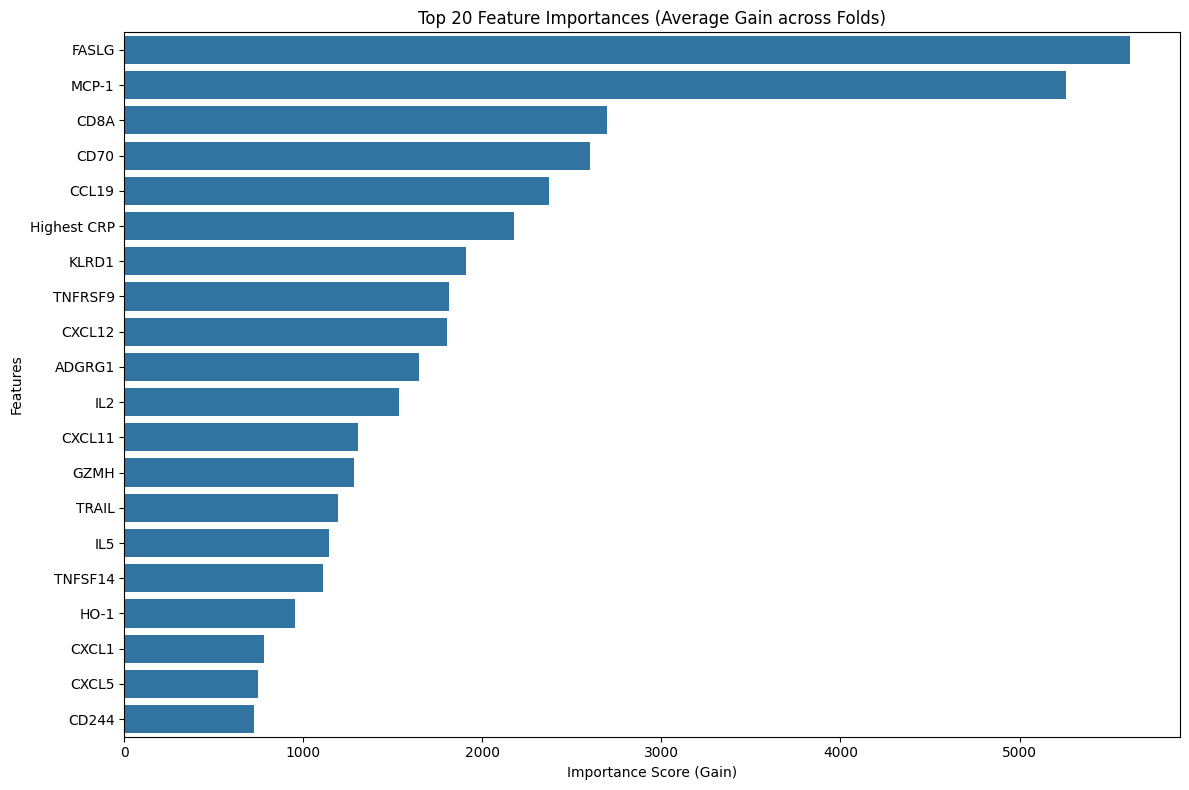

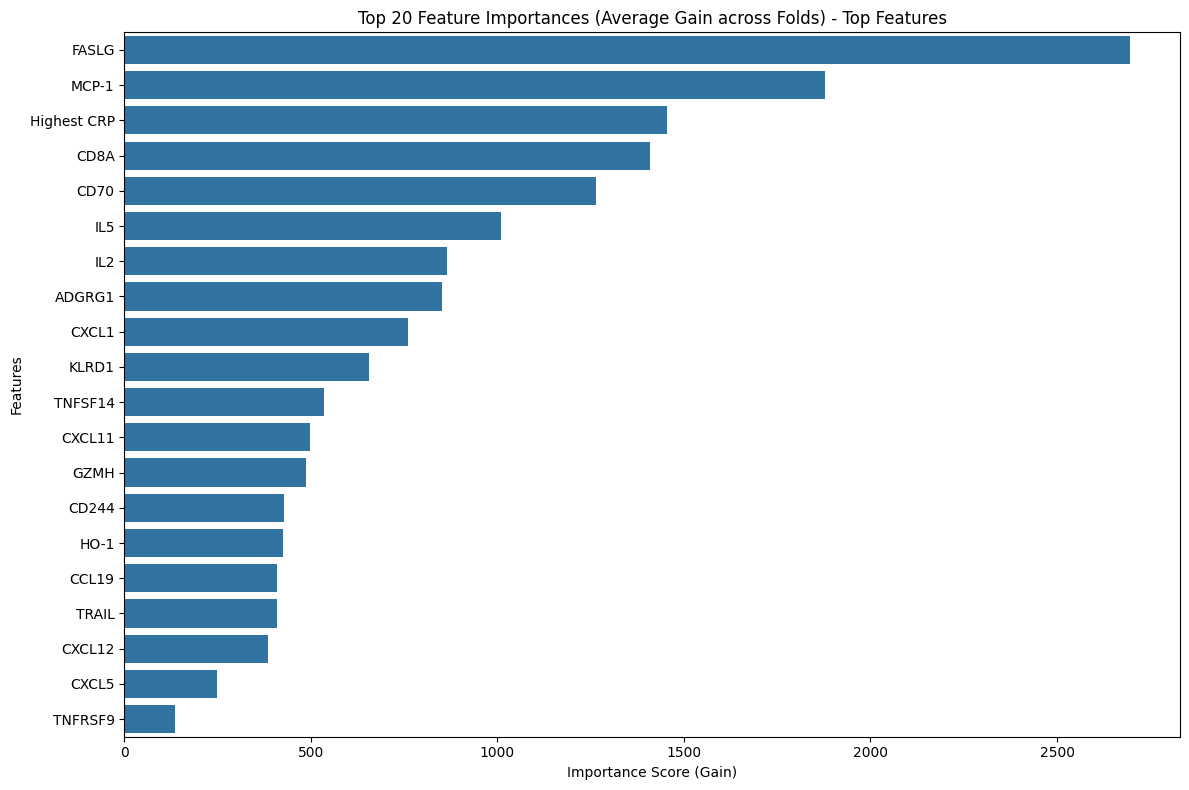

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:29:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Threshold: 0.75
Best F1-Score: 0.3949579831932773
Accuracy with Best Threshold: 0.9336
AUC-ROC with Best Threshold: 0.7277
Classification Report with Best Threshold:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     20005
           1       0.67      0.28      0.39      1683

    accuracy                           0.93     21688
   macro avg       0.81      0.63      0.68     21688
weighted avg       0.92      0.93      0.92     21688



In [14]:
# -*- coding: utf-8 -*-
"""modeling-V2.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1LUhqv2W-tbxWOvHuuKkrRGAPu19n60FN
"""

# Uncomment and run the following line if tslearn or other packages are not already installed
# !pip install tslearn imblearn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
from xgboost import XGBClassifier

from google.colab import drive
from datetime import timedelta

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final_data_clipped.csv", low_memory=False)
df.head(5)

# Define the complete_set as per your existing code
complete_set = [
    'PT_ID','CRS on date (0 No, 1 Yes)','Agent (JNJ/BMS/Caribou)','datetime',
    'spo2_avg', 'pulse_rate_avg','respiratory_rate_avg', 'covered_skin_temperature_avg',
    'covered_axil_temperature_avg','Highest Ferritin','Highest CRP','IL8','TNFRSF9',
    'TIE2','MCP-3','CD40-L','IL-1 alpha','CD244','EGF','ANGPT1','IL7','PGF','IL6',
    'ADGRG1','MCP-1','CRTAM','CXCL11','MCP-4','TRAIL','FGF2','CXCL9','CD8A','CAIX',
    'MUC-16','ADA','CD4','NOS3','IL2','Gal-9','VEGFR-2','CD40','IL18','GZMH',
    'KIR3DL1','LAP TGF-beta-1','CXCL1','TNFSF14','IL33','TWEAK','PDGF subunit B',
    'PDCD1','FASLG','CD28','CCL19','MCP-2','CCL4','IL15','Gal-1','PD-L1','CD27',
    'CXCL5','IL5','HGF','GZMA','HO-1','CX3CL1','CXCL10','CD70','IL10','TNFRSF12A',
    'CCL23','CD5','CCL3','MMP7','ARG1','NCR1','DCN','TNFRSF21','TNFRSF4','MIC-A/B',
    'CCL17','ANGPT2','PTN','CXCL12','IFN-gamma','LAMP3','CASP-8','ICOSLG','MMP12',
    'CXCL13','PD-L2','VEGFA','IL4','LAG3','IL12RB1','IL13','CCL20','TNF','KLRD1',
    'GZMB','CD83','IL12','CSF-1',
]

# Select the subset of columns
columns_test_1 = complete_set
df_subset = df[columns_test_1]
df_subset.head(5)

# Filter for JNJ and BMS agents
df_JNJ = df_subset[(df_subset['Agent (JNJ/BMS/Caribou)'] == 'JNJ') | (df_subset['Agent (JNJ/BMS/Caribou)'] == 'JNJ OOS')]
df_BMS = df_subset[(df_subset['Agent (JNJ/BMS/Caribou)'] == 'BMS')]

# Individualize the data by subtracting baseline values

##### Change this to category = "BMS" and data = df_BMS.copy() to calculate features for BMS########
##### Change this to category = "JNJ" and data = df_JNJ.copy() to calculate features for JNJ########

category = "BMS"  # Change to "JNJ" for JNJ data
data = df_BMS.copy()

baseline = data.groupby('PT_ID').first().reset_index()

if category == "BMS":
    missing_cols = set(complete_set) - set(df.columns)
    non_numeric_features = ['PT_ID', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'datetime']
    numeric_features = [col for col in data.columns if col not in non_numeric_features]
    if missing_cols:
        print(f"\nWarning: The following columns are missing from the dataset and will be excluded: {missing_cols}")
        complete_set = [col for col in complete_set if col not in missing_cols]
    for col in numeric_features:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    missing_values = data[numeric_features].isnull().sum()
    print("\nMissing Values in Numeric Features:")
    print(missing_values[missing_values > 0])

    # Fill missing values with the median of each column
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].median())

else:
    # Subtract the baseline values for numeric columns
    columns_to_individualize = [col for col in columns_test_1 if col not in ['PT_ID', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)','datetime']]

    for col in columns_to_individualize:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col] - data.groupby('PT_ID')[col].transform('first')

data.head()

# Assign CRS_in_6_hours
def assign_crs_in_6_hours(data):
    """
    Assign CRS_in_6_hours for each row based on whether `datetime + 6 hours` falls within a CRS occurrence time frame.
    """
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.sort_values(by=['PT_ID', 'datetime'])

    # Initialize a new column
    data['CRS_in_6_hours'] = 0

    # Process each patient group separately
    for pt_id, group in data.groupby('PT_ID'):
        group = group.sort_values('datetime')

        # Identify CRS occurrence start and end timeframes
        crs_start = group.index[(group['CRS on date (0 No, 1 Yes)'].shift(1) == 0) &
                                (group['CRS on date (0 No, 1 Yes)'] == 1)].tolist()
        crs_end = group.index[(group['CRS on date (0 No, 1 Yes)'].shift(1) == 1) &
                              (group['CRS on date (0 No, 1 Yes)'] == 0)].tolist()

        # If a CRS event starts but does not end, assume it continues until the last datetime
        if len(crs_start) > len(crs_end):
            crs_end.append(group.index[-1])

        # Assign CRS_in_6_hours for each row
        for start_idx, end_idx in zip(crs_start, crs_end):
            crs_start_time = group.loc[start_idx, 'datetime']
            crs_end_time = group.loc[end_idx, 'datetime']

            # Any datetime + 6 hours within the CRS occurrence timeframe is set to 1
            within_crs_timeframe = (group['datetime'] + timedelta(hours=6) >= crs_start_time) & \
                                   (group['datetime'] + timedelta(hours=6) <= crs_end_time)
            data.loc[group[within_crs_timeframe].index, 'CRS_in_6_hours'] = 1

    return data

# Apply the function to your dataset
data = assign_crs_in_6_hours(data)

data.shape

# Additional data exploration
data[data['CRS_in_6_hours'] == 1]
data[data['CRS_in_6_hours'] == 1].head(10)

# Define features and target

# Ensure datetime is in datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Define features and target
X = data.drop(columns=['PT_ID', 'datetime', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'CRS_in_6_hours'])
y = data['CRS_in_6_hours']
groups = data['PT_ID']  # For GroupKFold

# Handle any remaining missing values if present
X = X.fillna(X.median())

# Convert all features to numeric (if not already)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())

# -----------------------------------
# Step 1: Remove Highly Correlated Features
# -----------------------------------

def remove_highly_correlated_features(X, threshold=0.8):
    """
    Remove highly correlated features from the dataset.

    Parameters:
        X (DataFrame): Feature matrix.
        threshold (float): Correlation coefficient above which to consider features as highly correlated.

    Returns:
        X_reduced (DataFrame): Feature matrix with highly correlated features removed.
        dropped_features (list): List of features that were removed.
    """
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    X_reduced = X.drop(columns=to_drop)
    return X_reduced, to_drop

# Remove highly correlated features
X_reduced, dropped_features = remove_highly_correlated_features(X, threshold=0.8)

print(f"\nDropped {len(dropped_features)} highly correlated features:")
print(dropped_features)

# Update X to the reduced set
X = X_reduced.copy()

# -----------------------------------
# Step 2: Cross-Validation with GroupKFold
# -----------------------------------

# Initialize cross-validation strategy
n_splits = 5  # You can adjust the number of folds
cv = GroupKFold(n_splits=n_splits)

# Initialize lists to store evaluation metrics
accuracy_list = []
f1_list = []
auc_list = []
classification_reports = []

# Initialize feature importance dictionary
feature_importances = {}

# Define the pipeline with RandomOverSampler and XGBClassifier
pipeline = ImbPipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        scale_pos_weight=1,  # Placeholder, will adjust later
        random_state=42
    ))
])

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=groups)):
    print(f"\n=== Fold {fold + 1} ===")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Compute class weights based on the training set
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

    # Update scale_pos_weight in the classifier
    pipeline.named_steps['classifier'].set_params(scale_pos_weight=class_weights[1] / class_weights[0])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val)
    y_prob = pipeline.predict_proba(X_val)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Append metrics
    accuracy_list.append(accuracy)
    f1_list.append(f1)
    auc_list.append(auc)

    # Classification report
    report = classification_report(y_val, y_pred, output_dict=True)
    classification_reports.append(report)

    # Feature importances
    clf = pipeline.named_steps['classifier']
    fold_importances = clf.get_booster().get_score(importance_type='gain')
    for feature, importance in fold_importances.items():
        if feature in feature_importances:
            feature_importances[feature] += importance
        else:
            feature_importances[feature] = importance

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_list)
avg_f1 = np.mean(f1_list)
avg_auc = np.mean(auc_list)

print("\n=== Cross-Validation Results ===")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average AUC-ROC: {avg_auc:.4f}")

# -----------------------------------
# Step 3: Aggregate Feature Importances
# -----------------------------------

# Aggregate feature importances
importance_df = pd.DataFrame({
    'Feature': list(feature_importances.keys()),
    'Importance': list(feature_importances.values())
}).sort_values(by='Importance', ascending=False)

# Normalize importances by the number of folds
importance_df['Importance'] = importance_df['Importance'] / n_splits

# Display feature importances
print("\nFeature Importances (Average Gain across Folds):")
print(importance_df)

# -----------------------------------
# Step 4: Select Top N Features
# -----------------------------------

# Select top N features
TOP_N = 20  # Adjust based on your preference
top_features = importance_df['Feature'].head(TOP_N).tolist()
print(f"\nTop {TOP_N} Features:")
print(top_features)

# -----------------------------------
# Step 5: Retrain the Model Using Top Features with Cross-Validation
# -----------------------------------

# Initialize lists to store evaluation metrics for top features
accuracy_top_list = []
f1_top_list = []
auc_top_list = []
classification_reports_top = {}

# Define the pipeline with only top features
X_top = X[top_features]

# Initialize feature importance dictionary for top features
feature_importances_top = {}

# Iterate over each fold again with top features
for fold, (train_idx, val_idx) in enumerate(cv.split(X_top, y, groups=groups)):
    print(f"\n=== Fold {fold + 1} with Top Features ===")

    X_train, X_val = X_top.iloc[train_idx], X_top.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Compute class weights based on the training set
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

    # Update scale_pos_weight in the classifier
    pipeline.named_steps['classifier'].set_params(scale_pos_weight=class_weights[1] / class_weights[0])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_val)
    y_prob = pipeline.predict_proba(X_val)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Append metrics
    accuracy_top_list.append(accuracy)
    f1_top_list.append(f1)
    auc_top_list.append(auc)

    # Classification report
    report = classification_report(y_val, y_pred, output_dict=True)
    classification_reports_top[fold] = report

    # Feature importances
    clf = pipeline.named_steps['classifier']
    fold_importances_top = clf.get_booster().get_score(importance_type='gain')
    for feature, importance in fold_importances_top.items():
        if feature in feature_importances_top:
            feature_importances_top[feature] += importance
        else:
            feature_importances_top[feature] = importance

# Calculate average metrics across all folds for top features
avg_accuracy_top = np.mean(accuracy_top_list)
avg_f1_top = np.mean(f1_top_list)
avg_auc_top = np.mean(auc_top_list)

print("\n=== Cross-Validation Results with Top Features ===")
print(f"Average Accuracy: {avg_accuracy_top:.4f}")
print(f"Average F1-Score: {avg_f1_top:.4f}")
print(f"Average AUC-ROC: {avg_auc_top:.4f}")

# Aggregate feature importances for top features
importance_top_df = pd.DataFrame({
    'Feature': list(feature_importances_top.keys()),
    'Importance': list(feature_importances_top.values())
}).sort_values(by='Importance', ascending=False)

# Normalize importances by the number of folds
importance_top_df['Importance'] = importance_top_df['Importance'] / n_splits

# Display feature importances for top features
print("\nTop Features Importances (Average Gain across Folds):")
print(importance_top_df)

# -----------------------------------
# Step 6: Visualization
# -----------------------------------

# Plot feature importances for all selected features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(TOP_N))
plt.title(f'Top {TOP_N} Feature Importances (Average Gain across Folds)')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Plot feature importances for top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_top_df.head(TOP_N))
plt.title(f'Top {TOP_N} Feature Importances (Average Gain across Folds) - Top Features')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# -----------------------------------
# Optional: Threshold Optimization
# -----------------------------------

def find_best_threshold(y_true, y_prob, step=0.01):
    """
    Find the best threshold to maximize the F1-Score.

    Parameters:
        y_true (array-like): True binary labels.
        y_prob (array-like): Predicted probabilities for the positive class.
        step (float): Step size for threshold search.

    Returns:
        best_threshold (float): Threshold that gives the highest F1-Score.
        best_f1 (float): The highest F1-Score achieved.
    """
    best_threshold = 0.0
    best_f1 = 0.0
    for threshold in np.arange(0, 1 + step, step):
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

# Example: Find best threshold on the last fold's predictions with top features
# (Alternatively, you can aggregate predictions across folds if needed)
# Here, for simplicity, we'll demonstrate with the last fold

# Note: In practice, threshold optimization should be done within cross-validation or on a separate validation set

# Retrain on the last fold to get probabilities
fold = n_splits - 1  # Last fold
train_idx, val_idx = list(cv.split(X_top, y, groups=groups))[fold]
X_train, X_val = X_top.iloc[train_idx], X_top.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Update scale_pos_weight
pipeline.named_steps['classifier'].set_params(scale_pos_weight=class_weights[1] / class_weights[0])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict probabilities
y_prob = pipeline.predict_proba(X_val)[:, 1]

# Find best threshold
best_threshold_final, best_f1_final = find_best_threshold(y_val, y_prob, step=0.01)
print(f"\nBest Threshold: {best_threshold_final}")
print(f"Best F1-Score: {best_f1_final}")

# Apply the best threshold
y_pred_best = (y_prob >= best_threshold_final).astype(int)

# Re-evaluate the model with the best threshold
accuracy_best = accuracy_score(y_val, y_pred_best)
auc_best = roc_auc_score(y_val, y_prob)
print(f"Accuracy with Best Threshold: {accuracy_best:.4f}")
print(f"AUC-ROC with Best Threshold: {auc_best:.4f}")
print("Classification Report with Best Threshold:\n", classification_report(y_val, y_pred_best))
